## Import Libraries 

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn import preprocessing

from sklearn.naive_bayes import MultinomialNB

## Read Dataset

In [102]:

df=pd.read_csv("Amazon Fine Reviews.csv")


In [103]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Explarotary Data Analysis


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Our sample data has 568454 rows and 10 columns.

Because of the big data,while working functions and loops the kernel continuosly died.That's why I got the sample(size=50000)from the dataset to work.


In [105]:
sample_df = df.sample(n=50000)  

Since I will applying text classification I need only feature and text.That's why I created new dataframe for two feature a new 

In [106]:
df2=sample_df.copy()
df2=sample_df[["Score", "Text"]]
df2.head()

,Score,Text
410794,4,I love blue corn tortillas and their products....
255936,1,I ORDRED HI CHEWS FROM VERY ASIA AND THEY TOOK...
66547,5,So you know that weird aftertaste you get when...
150673,5,My mango ginger chews are fresh-tasting and ve...
178584,5,"Sent this gift as a surprise to my brother, wh..."


In [107]:
df2.isnull().sum()   #Here we once show that there is no null value in any column.  

Score    0
Text     0
dtype: int64

As we look at the distrubition of score , the score of 5 is much than others.It seems a little unbalanced. 

Text(0.5, 1.0, 'Score Distribution Across Dataset')

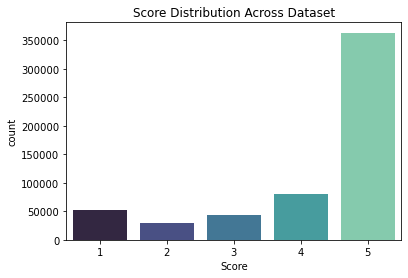

In [108]:
sns.countplot(data=df, x='Score', palette='mako').set_title('Score Distribution Across Dataset')

## Text Preprocessing and Cleaning

Test preporocessing is the most important part for the text classification task.The customer reviews includes too much noisy such as spelling mistakes,fat finger problems or punctuations mistakes.I need to clean up them firstly.
Secondly, I applied word tokenization to split sentences into words and remove stopwords.Because stopwords are noninformative words that means don't give any sentiment.
Thirdly,I applied lemmatization process to cover the word to its base form.

I chosed NLTK library to use this processes and I created cleanning function.

In [109]:
stop_words = stopwords.words('english')

for i in ["not", "no"]:
        stop_words.remove(i)

In [110]:
def cleaning(data):
    
    import re
    
   
    # To remove upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")
    
    # Tokenizing
    text_tokens = word_tokenize(data.lower())
    
    # To remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    # To removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    # Lemmatization
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)



After cleaning I added 'clean_text'column in the dataframe to see their difference.

In [111]:
df2['clean_text'] = df2['Text'].apply(lambda x: cleaning(x))
df2.head()



,Score,Text,clean_text
410794,4,I love blue corn tortillas and their products....,love blue corn tortilla product eating guiltle...
255936,1,I ORDRED HI CHEWS FROM VERY ASIA AND THEY TOOK...,ordred hi chew asia took forever get emailed a...
66547,5,So you know that weird aftertaste you get when...,know weird aftertaste get eat somewhat artific...
150673,5,My mango ginger chews are fresh-tasting and ve...,mango ginger chew slightly sweet zing ginger i...
178584,5,"Sent this gift as a surprise to my brother, wh...",sent gift surprise brother didnt like christma...


In [112]:
df2 =df2[["Score", "clean_text"]]    #The text column replaced with the clean_text column.
df2

,Score,clean_text
410794,4,love blue corn tortilla product eating guiltle...
255936,1,ordred hi chew asia took forever get emailed a...
66547,5,know weird aftertaste get eat somewhat artific...
150673,5,mango ginger chew slightly sweet zing ginger i...
178584,5,sent gift surprise brother didnt like christma...
...,...,...
550222,3,bit disappointed coffee par generic store bran...
279616,4,really chai latte starbucks need get since cha...
83493,3,reading review jumped foot ordered french roas...
558025,3,wish would tried diferent flavor taste much ta...


Checking the duplicated value according the text.It can be same text that score is different and this can be affect accuracy of models.

In [113]:
df2.duplicated(subset ="clean_text").value_counts()     

False    46231
True      3769
dtype: int64

In [114]:
df2.drop_duplicates(subset="clean_text",keep='first',inplace=True)   #deleting duplicated values.

To do sentiment analysis I covered the scoring number to positive and negative values.Above 3 refer to positive and 3 and below 3 refer to negative.

In [115]:
def rating(score):
    if score > 3:
        return 'Positive'

    else:
        return 'Negative'

In [116]:
df2['Score'] = df2['Score'].apply(rating) 


In [117]:
df2.head()   #Checking the score values.

,Score,clean_text
410794,Positive,love blue corn tortilla product eating guiltle...
255936,Negative,ordred hi chew asia took forever get emailed a...
66547,Positive,know weird aftertaste get eat somewhat artific...
150673,Positive,mango ginger chew slightly sweet zing ginger i...
178584,Positive,sent gift surprise brother didnt like christma...


## Splitting the Data into Training and Test Sets

In [118]:
X = df2["clean_text"]
y = df2["Score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (34673,)
X_test: (11558,)
y_train: (34673,)
y_test: (11558,)


## Feature Engineering

I used two different text representation technics one of which is Bag of Words vectorization and other one is TF-IDF vectorization.I chosed them because they are commonly used in text classification and they work good.I will compare their results below using traditional algorithms.
<br>
Differences between the two approaches:<br>
**Bag of Words**<br>
Creates vectors containing the count of words easier to interpret<br>
**TF-IDF**<br>
Contains information on which words are more important in the evaluation based on their significance


In [128]:
vectorizer = CountVectorizer()    #Bag of Words

X_train_bow = vectorizer.fit_transform(X_train).toarray()
X_test_bow = vectorizer.transform(X_test).toarray()



In [129]:
vectorizer.get_feature_names()

print('Bow_train:',X_train_bow.shape)
print('Bow_test:',X_test_bow.shape)

Bow_train: (34673, 30930)
Bow_test: (11558, 30930)


In [130]:
vectorizer.get_feature_names()          # the vectorized words-bow


['aa',
 'aaaa',
 'aaaaaaaaagghh',
 'aaaaaahhhhhyaaaaaa',
 'aaagh',
 'aacute',
 'aadults',
 'aaf',
 'aafco',
 'aah',
 'aahing',
 'aand',
 'aap',
 'ab',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'abates',
 'abbie',
 'abc',
 'abd',
 'abdomen',
 'abdominal',
 'aberdeen',
 'abhor',
 'abhorrent',
 'abhors',
 'abide',
 'abietate',
 'ability',
 'abit',
 'abject',
 'ablaze',
 'able',
 'abnormal',
 'abnormality',
 'abnormally',
 'aboard',
 'abomination',
 'abor',
 'aboslutely',
 'abosolutely',
 'abot',
 'abound',
 'abounds',
 'abour',
 'abowt',
 'abpve',
 'abroad',
 'abrubt',
 'abrupt',
 'abruptly',
 'abruptness',
 'absence',
 'absense',
 'absent',
 'absoluley',
 'absolut',
 'absolute',
 'absoluteley',
 'absolutely',
 'absolutey',
 'absolutley',
 'absolutly',
 'absoluttely',
 'absorb',
 'absorbable',
 'absorbed',
 'absorber',
 'absorbing',
 'absorbs',
 'absorbtion',
 'absorption',
 'absorptive',
 'absoulte',
 'absoultely',
 'absoulutely',
 'absoulutly',
 'absouluty',
 'absoute',
 'abst

In [119]:
tf_idf_vectorizer = TfidfVectorizer()     #TF-IDF 
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)



In [120]:
print('Tfidf_train:',X_train_tf_idf.shape)
print('Tfidf_test:',X_test_tf_idf.shape)

Tfidf_train: (34673, 30930)
Tfidf_test: (11558, 30930)


In [121]:
tf_idf_vectorizer.get_feature_names()        # the vectorized words-tf_idf

['aa',
 'aaaa',
 'aaaaaaaaagghh',
 'aaaaaahhhhhyaaaaaa',
 'aaagh',
 'aacute',
 'aadults',
 'aaf',
 'aafco',
 'aah',
 'aahing',
 'aand',
 'aap',
 'ab',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'abates',
 'abbie',
 'abc',
 'abd',
 'abdomen',
 'abdominal',
 'aberdeen',
 'abhor',
 'abhorrent',
 'abhors',
 'abide',
 'abietate',
 'ability',
 'abit',
 'abject',
 'ablaze',
 'able',
 'abnormal',
 'abnormality',
 'abnormally',
 'aboard',
 'abomination',
 'abor',
 'aboslutely',
 'abosolutely',
 'abot',
 'abound',
 'abounds',
 'abour',
 'abowt',
 'abpve',
 'abroad',
 'abrubt',
 'abrupt',
 'abruptly',
 'abruptness',
 'absence',
 'absense',
 'absent',
 'absoluley',
 'absolut',
 'absolute',
 'absoluteley',
 'absolutely',
 'absolutey',
 'absolutley',
 'absolutly',
 'absoluttely',
 'absorb',
 'absorbable',
 'absorbed',
 'absorber',
 'absorbing',
 'absorbs',
 'absorbtion',
 'absorption',
 'absorptive',
 'absoulte',
 'absoultely',
 'absoulutely',
 'absoulutly',
 'absouluty',
 'absoute',
 'abst

## Modelling with Traditional Classification Model 

I applied Multinomial Naive Bayes Algorithm for classification.I didn't create pipeline because it has only 3 parameters and only alpha value changed little my score. 

In [131]:
Model1 = MultinomialNB(alpha=0.1)            #Built on TFIDF
scores = cross_validate(Model1, X_train_tf_idf, y_train, scoring ='accuracy', cv = 3)
Model1.fit(X_train_tf_idf,y_train)
y_pred_tf_idf=Model1.predict(X_test_tf_idf)

print(Model1.score(X_train_tf_idf, y_train))
print(Model1.score(X_test_tf_idf, y_test))

0.8809736682721426
0.8215089115763973


In [132]:
def metrics(prediction, actual): 
    print('Confusion_matrix \n', confusion_matrix(actual, prediction))
    print('\nAccuracy:', accuracy_score(actual, prediction))
    print('\nclassification_report\n')
    print(classification_report(actual, prediction))
    
    
metrics(y_pred_tf_idf,y_test)

Confusion_matrix 
 [[ 639 1945]
 [ 118 8856]]

Accuracy: 0.8215089115763973

classification_report

              precision    recall  f1-score   support

           0       0.84      0.25      0.38      2584
           1       0.82      0.99      0.90      8974

    accuracy                           0.82     11558
   macro avg       0.83      0.62      0.64     11558
weighted avg       0.83      0.82      0.78     11558



In [133]:
Model1 = MultinomialNB(alpha=0.1)     #Built on BOW
scores = cross_validate(Model1, X_train_bow, y_train, scoring ='accuracy', cv = 3)
Model1.fit(X_train_bow,y_train)
y_pred_bow=Model1.predict(X_test_bow)

In [134]:
metrics(y_pred_bow, y_test)

Confusion_matrix 
 [[1637  947]
 [ 778 8196]]

Accuracy: 0.8507527253850147

classification_report

              precision    recall  f1-score   support

           0       0.68      0.63      0.65      2584
           1       0.90      0.91      0.90      8974

    accuracy                           0.85     11558
   macro avg       0.79      0.77      0.78     11558
weighted avg       0.85      0.85      0.85     11558



Our evalution metric is **F1 score** because our essential target to minimize **False negative** and **False positive** review for reliability of the website.According to traditional models,F1 Score of Multinomial Naive Bayes used BOW vectorization technic is better.




## Modelling with Deep Learning 

I used tensorfow/keras library and CNN(Convolutional Neural Network )for modelling.

In [122]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import metrics
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow import keras


In [123]:
vocab_size =2000
max_length = 2000
X_train_padded=pad_sequences(X_train_tf_idf.toarray().astype(int), maxlen = max_length, padding='pre', value = 0.0 )  
X_test_padded= pad_sequences(X_test_tf_idf.toarray().astype(int), maxlen = max_length ,padding='pre', value = 0.0)

In [136]:
Model_CNN = Sequential([
   Embedding(vocab_size,20, input_length=max_length),
    Conv1D(256, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Flatten(),
    Dense(1024,activation="relu"),
    Dense(512, activation='relu'),
    Dense(1, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.01)
Model_CNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

In [125]:
le = preprocessing.LabelEncoder()

In [126]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [138]:
history = Model_CNN.fit(X_train_padded, y_train,batch_size=256, epochs=5, validation_data=(X_test_padded, y_test))

Epoch 1/5
136/136 [==============================] - 310s 2s/step - loss: 0.5299 - acc: 0.7793 - val_loss: 0.5317 - val_acc: 0.7764
Epoch 2/5
136/136 [==============================] - 294s 2s/step - loss: 0.5298 - acc: 0.7793 - val_loss: 0.5314 - val_acc: 0.7764
Epoch 3/5
136/136 [==============================] - 251s 2s/step - loss: 0.5286 - acc: 0.7793 - val_loss: 0.5314 - val_acc: 0.7764
Epoch 4/5
136/136 [==============================] - 259s 2s/step - loss: 0.5287 - acc: 0.7793 - val_loss: 0.5319 - val_acc: 0.7764
Epoch 5/5
136/136 [==============================] - 269s 2s/step - loss: 0.5288 - acc: 0.7793 - val_loss: 0.5366 - val_acc: 0.7764


In [139]:
loss, accuracy = Model_CNN.evaluate(X_test_padded,y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

362/362 [==============================] - 18s 49ms/step - loss: 0.5366 - acc: 0.7764
Testing Accuracy is 77.64319181442261 


## Evaluation and Discussion 

At first,the accuracy score of CNN model was quite low by 7.06 %.To enhance the model I tried different hyperparameter such as loss function,optimizer and learning rate.Also I added flatten layerand I worked bigger data sample.The final model gave **77.64%** accuracy.<br>

In this text classification ,the best model is **Multinomial Naive Bayes Classification** with **85.07%** accuracy score.

**Limitations**

Because of the big data,while working CNN model the kernel continuosly died.That's why I got the sample(size=50000)from the dataset to work however the model couldn't learn the data well.Deep neural network models generlly work better with big dataset. Probably , our CNN model didn't give good score.

